In [1]:
import torch

class VectorQuantize(torch.nn.Module):
    def __init__(self, *, codebook_size, dim):
        super(VectorQuantize, self).__init__()
        self.codebook_size = codebook_size
        self.dim = dim

        self.codebook = torch.nn.Parameter(torch.rand(codebook_size, dim, requires_grad=True))
        
    def forward(self, x):
        distances = torch.cdist(x, self.codebook)
        codes = distances.argmin(dim=-1)
        quantized = self.codebook[codes]

        vq = (quantized - x).detach() + x

        commit_loss = torch.nn.functional.mse_loss(x, quantized.detach())
        codebook_loss = torch.nn.functional.mse_loss(x.detach(), quantized)

        loss = commit_loss + codebook_loss

        return vq, codes, loss





vq = VectorQuantize(codebook_size=8, dim=10)

x = torch.randn(4, 3, 10)
q, codes, commit = vq(x)
print(x.shape)
print(q.shape)
print(codes)


torch.Size([4, 3, 10])
torch.Size([4, 3, 10])
tensor([[6, 4, 5],
        [5, 0, 5],
        [5, 6, 0],
        [5, 6, 5]])


In [2]:
import torch
import torchvision


train_mnist = torchvision.datasets.MNIST(
    "./data",
    train=True,
    download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
    ])
)

test_mnist = torchvision.datasets.MNIST(
    "./data",
    train=False,
    download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
    ])
)


In [3]:
import torch

class VQVAE(torch.nn.Module):
    def __init__(self, *, input_dim, codebook_dim, vector_dim, num_embeddings):
        super(VQVAE, self).__init__()
        
        self.input_dim = input_dim
        self.codebook_dim = codebook_dim
        self.vector_dim = vector_dim
        self.num_embeddings = num_embeddings

        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(input_dim, 300),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(300, 300),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(300, vector_dim*num_embeddings),
            torch.nn.Sigmoid()
        )

        self.vq = VectorQuantize(
            dim = vector_dim,
            codebook_size = codebook_dim,
        )

        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(vector_dim*num_embeddings, 300),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(300, 300),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(300, input_dim),
            torch.nn.Sigmoid()
        )

    def encode(self, x):
        embeddings = self.encoder(x)
        embeddings = embeddings.view(embeddings.shape[0], self.num_embeddings, self.vector_dim)
        return embeddings

    def quantize(self, embeddings):
        quantized, codes, commit_loss = self.vq(embeddings)
        return quantized, codes, commit_loss

    def decode(self, x):
        return self.decoder(x)
    
    def decode_from_codes(self, codes):
        embeddings = self.vq.codebook[codes]
        flat_quantized = embeddings.view(embeddings.shape[0], -1)
        return self.decoder(flat_quantized)
    
    def forward(self, x, return_codes=False):
        embeddings = self.encode(x)
        quantized, codes, commit_loss = self.quantize(embeddings)
        flat_quantized = quantized.view(quantized.shape[0], -1)
        reconstructed = self.decode(flat_quantized)
        if return_codes:
            return reconstructed, codes, commit_loss
        
        return reconstructed, commit_loss


model = VQVAE(
    input_dim=784,
    codebook_dim=8,
    vector_dim=32,
    num_embeddings=16
)
model(torch.randn(10, 784))
model.decode_from_codes(torch.randint(0, 8, (10, 16)))


tensor([[0.5092, 0.4669, 0.4968,  ..., 0.4940, 0.4786, 0.5144],
        [0.5136, 0.4689, 0.5038,  ..., 0.4943, 0.4692, 0.5108],
        [0.5024, 0.4696, 0.4910,  ..., 0.4944, 0.4804, 0.5047],
        ...,
        [0.5121, 0.4626, 0.4920,  ..., 0.4936, 0.4812, 0.5067],
        [0.5054, 0.4786, 0.4906,  ..., 0.4920, 0.4792, 0.5113],
        [0.4977, 0.4619, 0.4972,  ..., 0.4837, 0.4719, 0.5071]],
       grad_fn=<SigmoidBackward0>)

In [4]:
from tqdm import tqdm

dl = torch.utils.data.DataLoader(train_mnist, batch_size=32, shuffle=True)
model = VQVAE(
    input_dim=784,
    codebook_dim=8,
    vector_dim=32,
    num_embeddings=16
).to("cuda")
loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(3):
    bar = tqdm(dl)
    for digit, _ in bar:
        digit = digit.to("cuda")
        digit = digit.view(digit.shape[0], 28 * 28)
        recostructed, commit = model(digit)
        error = loss_fn(recostructed, digit)

        loss = error + 0.1*commit
        bar.set_description(f"Loss: {loss.item():.2f} | Error: {error.item():.2f} | Commit: {commit.item():.2}")

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

  0%|          | 0/1875 [00:00<?, ?it/s]

Loss: 0.16 | Error: 0.15 | Commit: 0.04: 100%|██████████| 1875/1875 [00:08<00:00, 226.62it/s] 
Loss: 0.15 | Error: 0.15 | Commit: 0.038: 100%|██████████| 1875/1875 [00:07<00:00, 243.91it/s]
Loss: 0.14 | Error: 0.13 | Commit: 0.047: 100%|██████████| 1875/1875 [00:07<00:00, 242.16it/s]


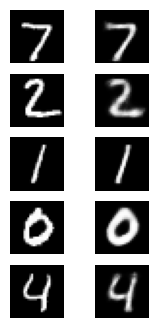

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, axes = plt.subplots(5, 2, figsize=(2, 4))

for i in range(5):
    digit = test_mnist[i][0].view(1, 28 * 28).to("cuda")
    reconstructed, codes, _ = model(digit, return_codes=True)

    axes[i][0].imshow(digit.view(28, 28).cpu().detach().numpy(), cmap="gray")
    axes[i][1].imshow(reconstructed.view(28, 28).cpu().detach().numpy(), cmap="gray")

    axes[i][0].axis("off")
    axes[i][1].axis("off")

plt.show()

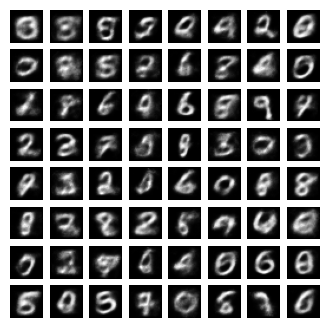

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, axes = plt.subplots(8, 8, figsize=(4, 4))
random_codes = torch.randint(0, 8, (8, 8, 16)).to("cuda")

for i in range(8):
    for j in range(8):
        reconstructed = model.decode_from_codes(random_codes[i, j].view(1, 16))

        axes[i, j].imshow(reconstructed.view(28, 28).cpu().detach().numpy(), cmap="gray")
        axes[i, j].axis("off")

plt.show()